Train: 14732 Validation: 818 Test: 819

🧾 Columns: Index(['id', 'dialogue', 'summary'], dtype='object')

🗨️ Sample Dialogue:
 Amanda: I baked  cookies. Do you want some?
Jerry: Sure!
Amanda: I'll bring you tomorrow :-)

📝 Sample Summary:
 Amanda baked cookies and will bring Jerry some tomorrow.

📊 Average dialogue length: 93.79274998302898
📊 Average summary length: 20.318444097481503


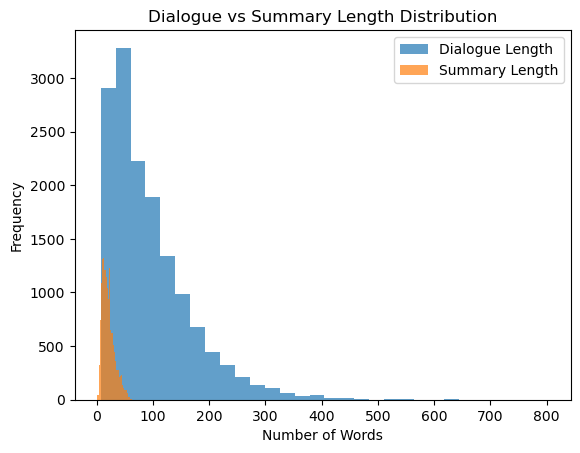

/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [1]:

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import (
    BertTokenizer, GPT2Tokenizer, EncoderDecoderModel, 
    GPT2LMHeadModel, BartTokenizer, BartForConditionalGeneration, pipeline
)
import torch
from torch.utils.data import Dataset, DataLoader

# 1. Load SAMSum dataset
splits = {'train': 'train.csv', 'validation': 'validation.csv', 'test': 'test.csv'}
df_train = pd.read_csv("hf://datasets/knkarthick/samsum/" + splits["train"])
df_val   = pd.read_csv("hf://datasets/knkarthick/samsum/" + splits["validation"])
df_test  = pd.read_csv("hf://datasets/knkarthick/samsum/" + splits["test"])

print("Train:", len(df_train), "Validation:", len(df_val), "Test:", len(df_test))
print("\n🧾 Columns:", df_train.columns)
print("\n🗨️ Sample Dialogue:\n", df_train['dialogue'].iloc[0])
print("\n📝 Sample Summary:\n", df_train['summary'].iloc[0])

# 2. Data cleaning and analysis
df_train = df_train.dropna(subset=['dialogue'])
df_train['dialogue'] = df_train['dialogue'].astype(str)
df_train['dialogue_length'] = df_train['dialogue'].apply(lambda x: len(x.split()))
df_train['summary_length'] = df_train['summary'].apply(lambda x: len(str(x).split()))

print("\n📊 Average dialogue length:", df_train['dialogue_length'].mean())
print("📊 Average summary length:", df_train['summary_length'].mean())

plt.hist(df_train['dialogue_length'], bins=30, alpha=0.7, label='Dialogue Length')
plt.hist(df_train['summary_length'], bins=30, alpha=0.7, label='Summary Length')
plt.title("Dialogue vs Summary Length Distribution")
plt.legend()
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

# 3. Tokenization setup
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token


In [3]:
# 6. Encoder-Decoder model (BERT + GPT-2)

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import pipeline

# Define summarization pipeline

tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-base")
summarizer = pipeline("summarization", model=model, tokenizer=tokenizer)


# Try on example input
sample_text = "Hi John, I wanted to catch up about the meeting. Sure, how’s 3 PM? That works. Let’s meet at the cafe."
summary = summarizer(sample_text, max_length=60, min_length=10, do_sample=False)
print("\n📌 Example Summary by BART:\n", summary[0]["summary_text"])

print("\n✅ Models and data ready for training!")


Your max_length is set to 60, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)



📌 Example Summary by BART:
 Hi John, I wanted to catch up about the meeting. Sure, how’s 3 PM? That works. Let’re meet at the cafe.

✅ Models and data ready for training!


In [5]:
df_train = df_train.sample(100, random_state=42).reset_index(drop=True)
df_val = df_val.sample(20, random_state=42).reset_index(drop=True)

from torch.utils.data import Dataset

class SummarizationDataset(Dataset):
    def __init__(self, dataframe, tokenizer, source_col, target_col, max_input_length=512, max_target_length=64):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.source_col = source_col
        self.target_col = target_col
        self.max_input_length = max_input_length
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        source = self.data.loc[idx, self.source_col]
        target = self.data.loc[idx, self.target_col]

        source_enc = self.tokenizer(
            source,
            max_length=self.max_input_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt",
        )
        target_enc = self.tokenizer(
            target,
            max_length=self.max_target_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt",
        )

        return {
            "input_ids": source_enc["input_ids"].squeeze(),
            "attention_mask": source_enc["attention_mask"].squeeze(),
            "labels": target_enc["input_ids"].squeeze()
        }

# 5. Build datasets and loaders
train_ds = SummarizationDataset(df_train, tokenizer, source_col="dialogue", target_col="summary")
val_ds = SummarizationDataset(df_val, tokenizer, source_col="dialogue", target_col="summary")

from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=4)

print("\n📦 Batches - Train:", len(train_loader), "Val:", len(val_loader))

# Loss function and optimizer
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW

# Make sure you're using the right device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model.to(device)

# Define optimizer and loss
optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = CrossEntropyLoss()




📦 Batches - Train: 25 Val: 5


In [11]:
import evaluate
import torch

# Load the ROUGE evaluation metric
rouge = evaluate.load("rouge")

# Evaluation function
def evaluate_model(model, val_loader, tokenizer, num_samples=10):
    model.eval()
    predictions = []
    references = []

    print("\n🔍 Sample Predictions vs. References:\n")

    for i, batch in enumerate(val_loader):
        input_ids = batch["input_ids"].to(model.device)
        attention_mask = batch["attention_mask"].to(model.device)
        labels = batch["labels"].to(model.device)

        with torch.no_grad():
            outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=60)

        decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

        predictions.extend(decoded_preds)
        references.extend(decoded_labels)

        # Show a few samples for qualitative analysis
        if i < num_samples:
            print(f"\n🗨️ Dialogue:\n{tokenizer.decode(input_ids[0], skip_special_tokens=True)}")
            print(f"✅ Reference Summary:\n{decoded_labels[0]}")
            print(f"🤖 Generated Summary:\n{decoded_preds[0]}")

    # Compute ROUGE scores
    results = rouge.compute(predictions=predictions, references=references, use_stemmer=True)
    
    print("\n ROUGE Scores:")
    for key, value in results.items():
        print(f"{key}: {value:.4f}")


    return results

In [ ]:
# Training function

def train(model, train_loader, val_loader=None, epochs=3):
    model.train()
    
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        avg_loss = total_loss / len(train_loader)
        print(f"✅ Epoch {epoch+1} complete | Avg Loss: {avg_loss:.4f}")

        # Evaluation after each epoch
        if val_loader:
            evaluate_model(model, val_loader, tokenizer)


train(model.to(device), train_loader, val_loader, epochs=3)


✅ Epoch 1 complete | Avg Loss: 2.8163

🔍 Sample Predictions vs. References:


🗨️ Dialogue:
Edd: wow, did you hear that they're transferring us to a different department?
Rose: whaaaaat :o
Rose: no! where'd you hear that?
Edd: well, it's quite official
Edd: Anderson just told us
Rose: and do you know what it changes for us?
Edd: they won't change the professors
Edd: but i know the paperwork will get trickier
Rose: and i guess that is a move that is supposed to make everything easier
Edd: yeah, guess so
Edd: they have a funny way of understanding 'to make things easier'
✅ Reference Summary:
Rose and Edd will be transferred to a new department. Their professors will not change but paperwork will become more difficult.
🤖 Generated Summary:
Rose and Eddie are transferring the professors to a different department.

🗨️ Dialogue:
Iza: <file_other>
Monica: OMG
Monica: yesssssss!!!
Iza: I know 
Iza: I have been waiting for this for so long!
Monica: me too!
Monica: :D 
✅ Reference Summary:
Iza ha